In [1]:
## Bases teóricas

    # A cidade não é uma massa homogênea, heterogeneidade
    # As polĩticas públicas dependem de domĩnios geográficos e atributos simples para seu sucesso
    # Quanto maior a velocidade da via maior a sinistralidade
    # As vias locais tem sinistralidade mais baixa
    

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import libpysal as lps
%matplotlib inline 

In [3]:
n_clusters = 5

In [4]:
df_meip = pd.read_csv('data/df_meip_v_02.csv', sep=';', decimal=',')\
    .set_index('od_id')

In [5]:
gdf_od = gpd.read_file('data/zonas-OD-2017-São-Paulo.gpkg')


In [6]:
modelo = [
    "ren_median_f",
    "sin_tot",
    "p_atrop_sin",
    "fatalid",
    "atrop_desl",
    "p_atrop_esc",
    "p_atrop_auto",
    "p_atrop_moto",
    "p_atrop_onibus",
    "p_atrop_caminh",
    "p_atrop_bicicl",
    "p_atrop_tr_mo",
    "p_atrop_pri",
    "p_atrop_sec_ter",
    "p_atrop_loc",
    "p_atrop_ati",
    "p_atrop_rur",
    "p_atrop_rap",
    "p_atrop_len",
    "CA_medio",
    "p_n_resid",
    "p_fam_n_motor",
    "p_fx_ped_at",
    "med_calc",
    "dens_ilumi",
    "inters_crit",
    "dem_sem_at_osm",
    "w_CMA_15",
    "w_CMP_15",
    "b_CMA_30",
    "b_CMP_30",
    "pt_CMA_60",
    "pt_CMP_60",
    "c_CMA_60",
    "c_CMP_60",
    "c_CMAS_15",
]

In [7]:
len(modelo)

36

In [8]:
for a in modelo:
    if df_meip[a].dtype == 'object': 
        df_meip[a] = pd.to_numeric(df_meip[a], errors='coerce').fillna(0)
        print(a)
        print(df_meip[a].isna().value_counts())

ren_median_f
False    342
Name: ren_median_f, dtype: int64
dem_sem_at_osm
False    342
Name: dem_sem_at_osm, dtype: int64


In [9]:
df_meip.fillna(0, inplace=True)

In [10]:
wq = lps.weights.Queen.from_dataframe(gdf_od)

In [11]:
wq.transform = 'r'

In [12]:
for m in modelo:
    df_meip[f'{m}_vizinhos'] = lps.weights.lag_spatial(wq, df_meip[m])

In [13]:
modelo_vizinhanca = modelo + [m + "_vizinhos" for m in modelo]

In [14]:
scaler = MinMaxScaler((-1,1))

In [15]:
kmeanModel = KMeans(n_clusters=n_clusters)
kmeanModel.fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))

KMeans(n_clusters=5)

In [16]:
taxonomia = {
    0:"centro sudoeste",
    1:"extrema periferia",
    2:"média periferia",
    3:"cinturão das marginais",
    4:"centro",
}

In [17]:
sns.set(rc={"figure.figsize":(10, 10)})

<AxesSubplot: >

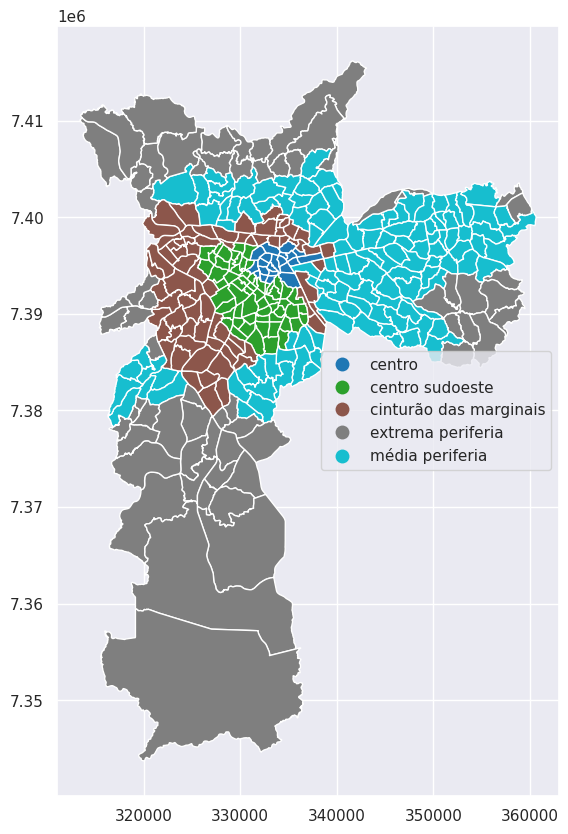

In [18]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
df_meip['k_cluster'] = kmeans.labels_
df_meip['k_labels'] = [taxonomia[k] for k in kmeans.labels_]
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_labels', legend=True, categorical=True, legend_kwds={'loc': 'center right'})

In [19]:
df_meip.loc[:, modelo + ['k_cluster', 'k_labels']].set_index('k_labels').groupby('k_labels').quantile(.50).style.background_gradient().format(precision=2)

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,p_atrop_bicicl,p_atrop_tr_mo,p_atrop_pri,p_atrop_sec_ter,p_atrop_loc,p_atrop_ati,p_atrop_rur,p_atrop_rap,p_atrop_len,CA_medio,p_n_resid,p_fam_n_motor,p_fx_ped_at,med_calc,dens_ilumi,inters_crit,dem_sem_at_osm,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15,k_cluster
k_labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
centro,3044.00,145.00,37.08,2.48,15.00,15.40,21.61,7.69,5.13,0.65,0.43,5.06,12.00,46.58,22.09,1.16,0.00,26.74,23.40,6.83,56.08,63.97,27.78,3.13,27.76,325.00,0.00,20528.00,12493.00,249275.00,213111.00,2511222.00,3593945.00,4887362.00,9475393.00,104.00,4.00
centro sudoeste,6143.00,82.00,14.34,1.30,5.00,5.42,11.66,3.62,1.49,0.00,0.00,0.00,14.29,33.33,36.00,0.00,0.00,17.14,36.67,5.53,19.68,26.50,20.80,3.07,25.21,326.00,0.00,12010.00,15740.00,311999.00,309762.00,1986184.00,2400110.00,4865763.00,8918022.00,98.00,0.00
cinturão das marginais,4500.00,163.00,13.85,2.17,6.00,8.69,11.17,5.24,1.75,0.00,0.00,15.79,28.57,23.91,19.57,0.00,0.00,46.30,22.73,3.43,16.23,33.10,14.42,2.50,22.18,480.00,0.00,5218.00,6285.00,84061.00,117193.00,1493188.00,1822632.00,4746415.00,8588398.00,49.00,3.00
extrema periferia,2453.00,138.00,18.43,3.02,8.00,10.54,11.94,7.18,2.07,0.59,0.00,0.00,6.85,27.27,36.00,0.00,0.00,25.71,39.44,0.72,13.32,48.24,4.31,2.07,24.64,251.00,0.00,1744.00,5413.00,31733.00,102108.00,276365.00,600573.00,2791141.00,6467843.00,16.00,1.00
média periferia,2926.50,209.00,28.75,3.12,13.00,14.73,18.59,8.67,2.73,0.57,0.00,0.00,5.82,47.38,30.67,0.00,0.00,15.69,32.11,1.37,14.75,44.01,9.20,2.04,30.16,412.50,0.00,4397.00,13895.00,91960.50,293165.50,800105.00,1527765.50,4032750.00,8510800.50,48.00,2.00


In [27]:
df_meip[[m + "_vizinhos" for m in modelo]]

,ren_median_f_vizinhos,sin_tot_vizinhos,p_atrop_sin_vizinhos,fatalid_vizinhos,atrop_desl_vizinhos,p_atrop_esc_vizinhos,p_atrop_auto_vizinhos,p_atrop_moto_vizinhos,p_atrop_onibus_vizinhos,p_atrop_caminh_vizinhos,...,dem_sem_at_osm_vizinhos,w_CMA_15_vizinhos,w_CMP_15_vizinhos,b_CMA_30_vizinhos,b_CMP_30_vizinhos,pt_CMA_60_vizinhos,pt_CMP_60_vizinhos,c_CMA_60_vizinhos,c_CMP_60_vizinhos,c_CMAS_15_vizinhos
od_id,,,,,,,,,,,,,,,,,,,,,
1,3137.600000,203.800000,60.954000,6.088000,25.400000,26.802000,31.182000,14.396000,11.196000,1.472000,...,0.0,32202.200000,17874.400000,327463.000000,277970.600000,2.685769e+06,4.169024e+06,4.912631e+06,9.424461e+06,132.800000
2,3307.555556,144.333333,35.283333,3.327778,14.333333,14.572222,20.583333,9.234444,5.030000,0.995556,...,0.0,20483.111111,12719.000000,246256.444444,211416.777778,2.488230e+06,3.788773e+06,4.885458e+06,9.525449e+06,104.666667
3,3595.000000,151.833333,39.211667,3.168333,15.666667,15.781667,22.738333,9.256667,5.198333,0.685000,...,0.0,24331.166667,19001.833333,345608.166667,277679.666667,2.456488e+06,3.659284e+06,4.920262e+06,9.435312e+06,132.833333
4,3435.714286,117.000000,34.237143,3.280000,13.000000,15.290000,20.454286,6.685714,5.445714,0.385714,...,0.0,30327.428571,23686.142857,388621.571429,317073.428571,2.503789e+06,3.688076e+06,4.922841e+06,9.346338e+06,139.285714
5,3126.400000,189.400000,50.844000,4.858000,21.000000,22.132000,28.248000,11.326000,8.798000,1.034000,...,0.0,32293.800000,21360.000000,364614.000000,314864.600000,2.594870e+06,3.869865e+06,4.911117e+06,9.283031e+06,135.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,3168.333333,136.500000,11.810000,1.556667,5.333333,7.223333,9.735000,5.096667,0.940000,0.885000,...,0.0,3871.333333,5052.666667,45221.833333,71306.166667,1.126112e+06,9.505837e+05,4.651314e+06,7.866740e+06,28.666667
339,5575.142857,206.857143,14.975714,1.791429,7.000000,8.085714,11.184286,7.001429,1.951429,0.241429,...,0.0,3771.571429,5724.142857,63777.285714,99299.000000,1.494344e+06,1.434941e+06,4.606678e+06,7.775445e+06,41.000000
340,6192.500000,173.166667,11.671667,1.705000,5.166667,7.306667,9.271667,4.355000,2.456667,0.180000,...,0.0,6438.666667,3716.500000,92851.333333,92629.833333,1.762594e+06,1.746023e+06,4.685220e+06,7.970830e+06,49.666667


In [31]:
import pingouin as pg

In [61]:
pg.corr(df_meip["sin_tot"],df_meip["CA_medio"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.151357,"[-0.25, -0.05]",0.005031,3.403,0.802916


In [52]:
pg.corr(df_meip["sin_tot"],df_meip["p_fx_ped_at"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.163332,"[-0.26, -0.06]",0.002447,6.539,0.859592


In [54]:
sns.set(rc={"figure.figsize":(7, 5)})

<AxesSubplot: xlabel='sin_tot', ylabel='CA_medio'>

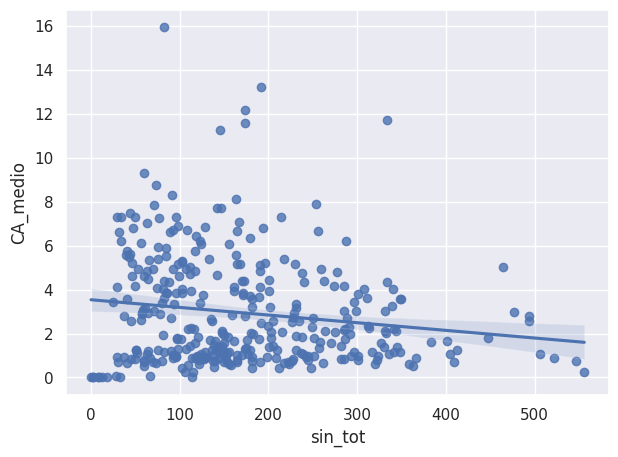

In [62]:
sns.regplot(x=df_meip["sin_tot"], y=df_meip["CA_medio"])

<AxesSubplot: xlabel='sin_tot', ylabel='p_fx_ped_at'>

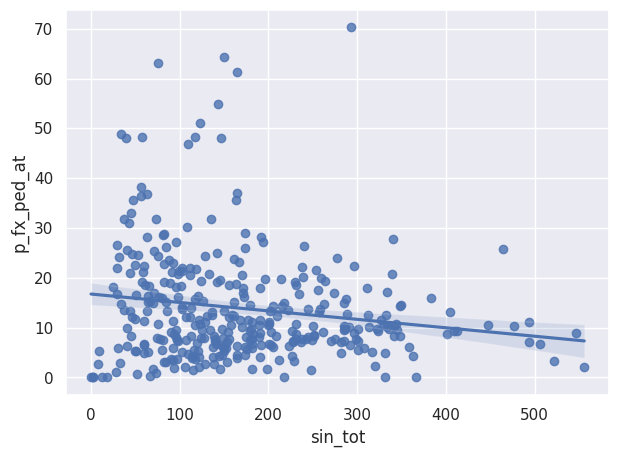

In [60]:
sns.regplot(x=df_meip["sin_tot"], y=df_meip["p_fx_ped_at"])
#pg.partial_corr(data=df_meip, x='fatalid', y='p_fx_ped_at')

In [76]:
sns.set(rc={"figure.figsize":(7, 5)})

<AxesSubplot: xlabel='ren_median_f', ylabel='fatalid'>

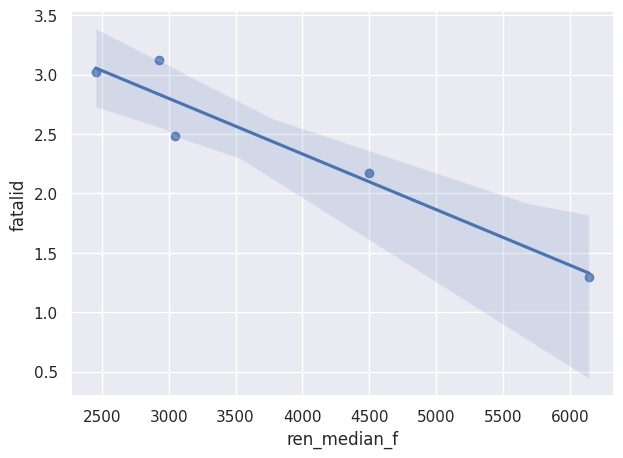

In [77]:
df_clusters = df_meip.loc[:, modelo + ['k_cluster', 'k_labels']].set_index('k_labels').groupby('k_labels').quantile(.50)
sns.regplot(x=df_clusters["ren_median_f"], y=df_clusters["fatalid"])

In [78]:
pg.corr(df_clusters["ren_median_f"], df_clusters["fatalid"])

,n,r,CI95%,p-val,BF10,power
pearson,5,-0.957437,"[-1.0, -0.48]",0.010473,5.7,0.826664


<AxesSubplot: >

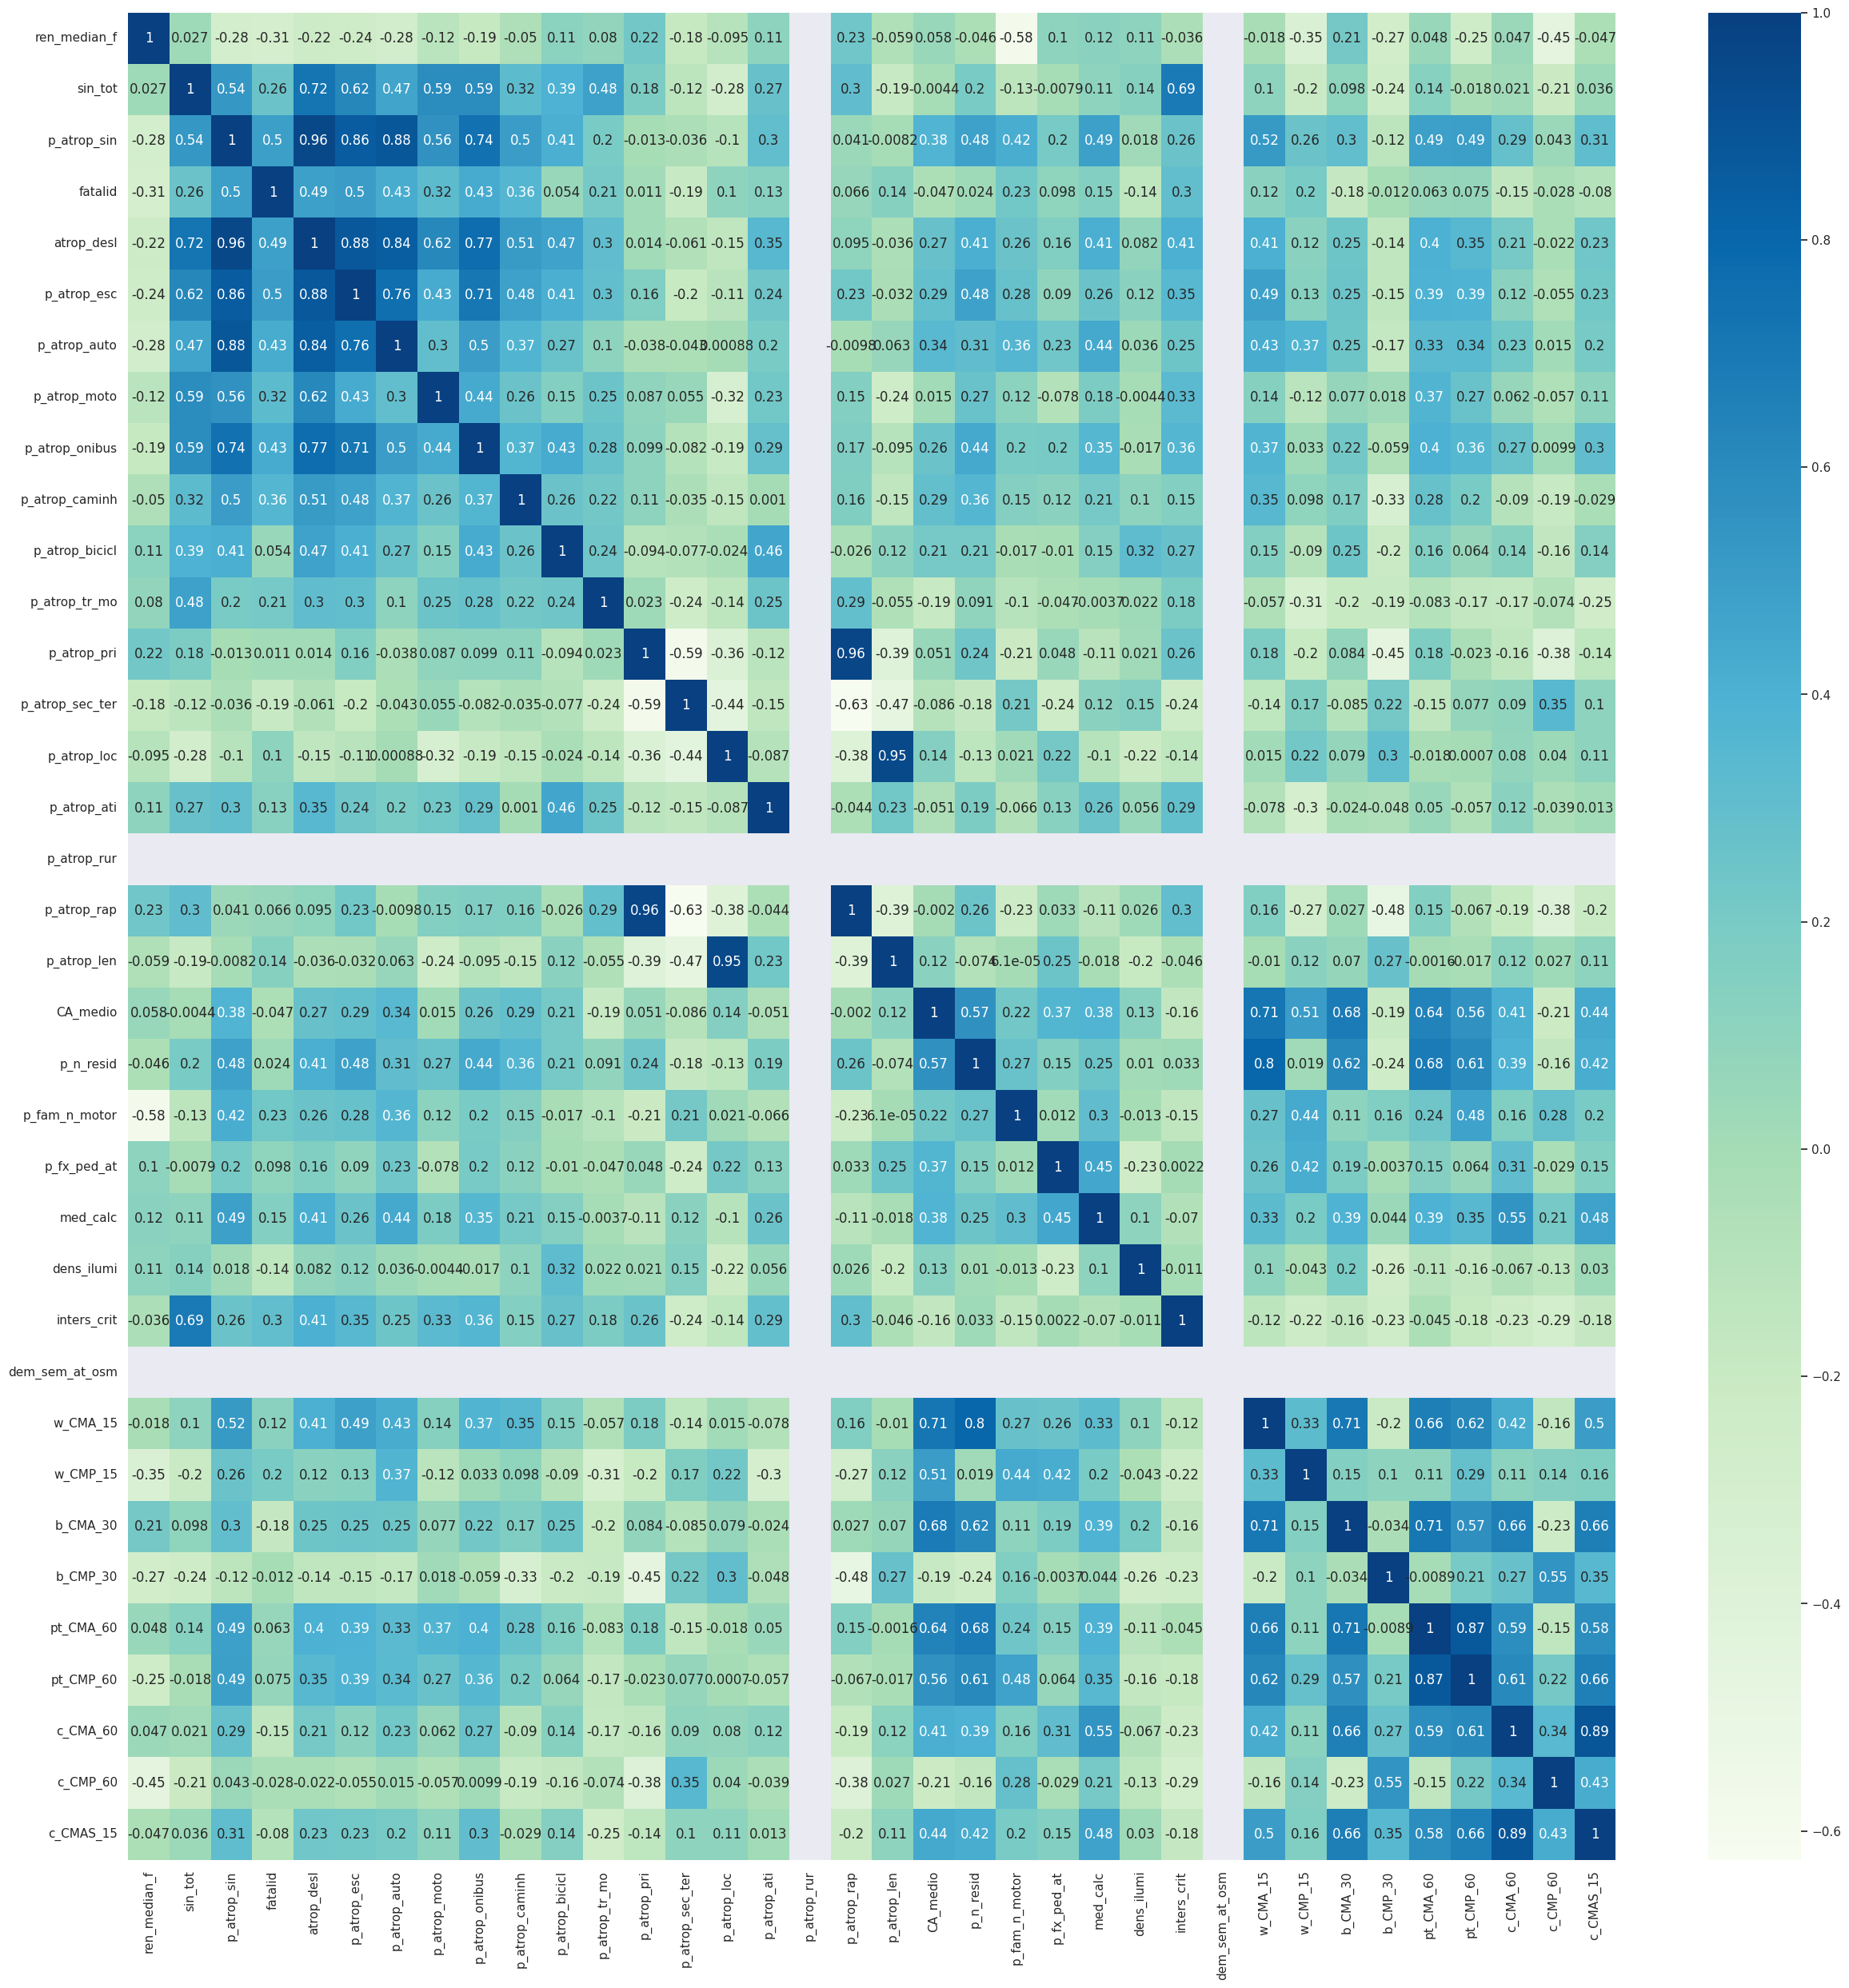

In [63]:
sns.set(rc={"figure.figsize":(30, 30)})
correlacao_modelo = df_meip.loc[df_meip['k_cluster'] == 0, modelo].corr()
sns.heatmap(correlacao_modelo, cmap="GnBu", annot=True)

In [72]:
gdf_zona_merged.to_file('resultados/k_clusters.gpkg')

In [ ]:
gdf_